# Success analysis

This notebook analyses re-execution success rate for different versions of R

In [1]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd

# plot style
sns.set_style('whitegrid')
sns.set_style({'font.family': 'Times New Roman'})

# Read all files

In [3]:
df_32_noenv = pd.read_csv("data/run_log_r32_no_env.csv", sep="\t", names=["doi", "file", "result"])
df_32_env = pd.read_csv("data/run_log_r32_env.csv", sep="\t", names=["doi", "file", "result"])
df_36_noenv = pd.read_csv("data/run_log_r36_no_env.csv", sep="\t", names=["doi", "file", "result"])
df_36_env = pd.read_csv("data/run_log_r36_env.csv", sep="\t", names=["doi", "file", "result"])
df_40_noenv = pd.read_csv("data/run_log_r40_no_env.csv", sep="\t", names=["doi", "file", "result"])
df_40_env = pd.read_csv("data/run_log_r40_env.csv", sep="\t", names=["doi", "file", "result"])

# Files with download error

In [4]:
er_361 = pd.read_csv("data/run_log_r36_no_env_download.csv", sep="\t", names=["doi", "fileid", "status"])
er_362 = pd.read_csv("data/run_log_r36_env_download.csv", sep="\t", names=["doi", "fileid", "status"])
er_321 = pd.read_csv("data/run_log_r32_no_env_download.csv", sep="\t", names=["doi", "fileid", "status"])
er_322 = pd.read_csv("data/run_log_r32_env_download.csv", sep="\t", names=["doi", "fileid", "status"])
er_401 = pd.read_csv("data/run_log_r40_no_env_download.csv", sep="\t", names=["doi", "fileid", "status"])
er_402 = pd.read_csv("data/run_log_r40_env_download.csv", sep="\t", names=["doi", "fileid", "status"])

In [5]:
error_data = [er_321, er_322, er_361, er_362, er_401, er_402]

In [6]:
exclude = []
print("All files" +"   "+ "Files with error" +"   "+ "DOIs with error")
for er in error_data:
    temp = er[er.status != 'ok']
    bad_dois = temp['doi'].unique().tolist()
    exclude.append(set(bad_dois))
    print(str(len(er)) +"        "+ str(len(temp)) +"                "+ str(len(bad_dois)))

All files   Files with error   DOIs with error
2833        837                65
2583        820                61
2797        781                66
2894        860                71
2751        822                63
2828        846                68


In [7]:
bad_dois = exclude[0] & exclude[1] & exclude[2] & exclude[3] & exclude[4] & exclude[5]

In [8]:
bad_dois = list(bad_dois)

In [9]:
len(bad_dois)

55

# Code cleaning analysis 

In [10]:
df_36 = pd.merge(df_36_noenv, df_36_env,on=['doi','file'], how='inner')

# Success analysis

In [11]:
def remove_bad_dois(df):
    df = df[~df.doi.isin(bad_dois)]
    return df

def get_success_rates(df):
    print "Total number of entries: "+ str(len(df))
    df = remove_bad_dois(df)
    print "Total number after bad DOIs are removed: "+ str(len(df))
    
    print "Unique DOIs: "+ str(len(df['doi'].unique()))
    
    # calculate success
    success = (df['result'] == 'success').sum()
    print "Success: " + str(success)+ " out of " + str(len(df)) +" => "+ str(success*1.0/len(df))
    
    til = (df['result'] == 'time limit exceeded').sum()
    print "TIL: " + str(til)+ " out of " + str(len(df)) +" => "+ str(til*1.0/len(df))
    
    error = len(df)-til-success
    print "Error: " + str(error)+ " out of " + str(len(df)) +" => "+ str(error*1.0/len(df))
    
    return [til, error, success]

# Aggregated analysis 

(aggregated per dataset, ie, DOI)

- If a replication package contains successful code => it is success
- If a replication package containes TLE code => it is TLE
- Rest is failed

In [12]:
def get_aggregated(df):
    df = remove_bad_dois(df)

    ag_tot = set(df['doi'].unique().tolist())
    ag_exc = set(df[df.result == 'time limit exceeded']['doi'].unique().tolist())
    ag_suc = set(df[df.result == 'success']['doi'].unique().tolist())

    ag_exc = ag_exc - ag_suc
    ag_failed = ag_tot - ag_suc - ag_exc

    return [len(ag_exc), len(ag_failed), len(ag_suc)]

In [13]:
def plot_code(df, plot_title, plot_name, aggregation=False):
    labels = ["Time Limit Exceeded",'Error', 'Success']
    if aggregation:
        sizes = get_aggregated(df)
    else:
        sizes = get_success_rates(df)
     
    fig1, ax1 = plt.subplots()
    plt.rcParams['font.size'] = 16
    ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=40,  \
            textprops={'fontsize': 14},wedgeprops={'alpha':0.6})

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')

    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.title(plot_title, size=20)
    plt.tight_layout()

    plt.show()
    fig1.savefig("plots/{}".format(plot_name), dpi=100)

# R 3.6

Total number of entries: 4042
Total number after bad DOIs are removed: 3943
Unique DOIs: 1298
Success: 580 out of 3943 => 0.14709611970580777
TIL: 8 out of 3943 => 0.002028911995942176
Error: 3355 out of 3943 => 0.85087496829825


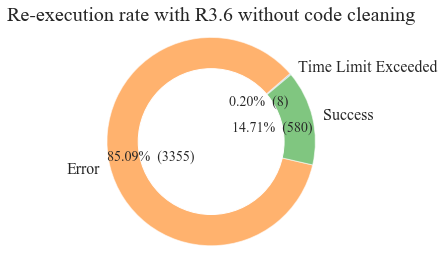

In [16]:
plot_code(df_36_noenv, "Re-execution rate with R3.6 without code cleaning", "no_env_before.png")

Total number of entries: 6226
Total number after bad DOIs are removed: 6001
Unique DOIs: 2026
Success: 1254 out of 6001 => 0.2089651724712548
TIL: 273 out of 6001 => 0.04549241793034494
Error: 4474 out of 6001 => 0.7455424095984002


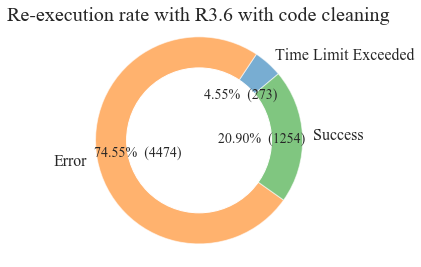

In [17]:
plot_code(df_36_env, "Re-execution rate with R3.6 with code cleaning", "r36_env.png")

# R 3.2

Total number of entries: 5028
Total number after bad DOIs are removed: 4935
Unique DOIs: 1837
Success: 882 out of 4935 => 0.17872340425531916
TIL: 293 out of 4935 => 0.059371833839918946
Error: 3760 out of 4935 => 0.7619047619047619


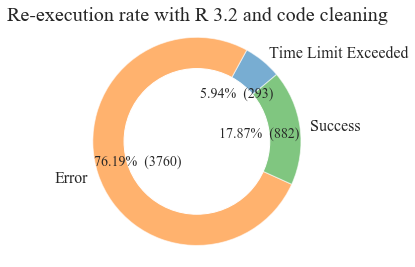

In [18]:
plot_code(df_32_env, "Re-execution rate with R 3.2 and code cleaning", "r32_env.png")

Total number of entries: 7088
Total number after bad DOIs are removed: 6848
Unique DOIs: 1963
Success: 743 out of 6848 => 0.10849883177570094
TIL: 1 out of 6848 => 0.00014602803738317756
Error: 6104 out of 6848 => 0.8913551401869159


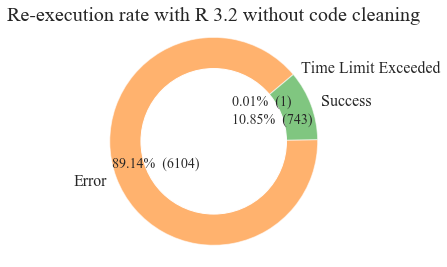

In [19]:
plot_code(df_32_noenv, "Re-execution rate with R 3.2 without code cleaning", "r32_noenv.png")

# R 4.0

Total number of entries: 5288
Total number after bad DOIs are removed: 5082
Unique DOIs: 2012
Success: 979 out of 5082 => 0.19264069264069264
TIL: 712 out of 5082 => 0.14010232192050373
Error: 3391 out of 5082 => 0.6672569854388036


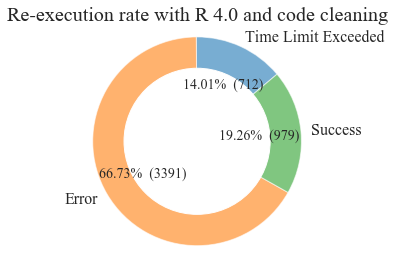

In [20]:
plot_code(df_40_env, "Re-execution rate with R 4.0 and code cleaning", "r40_env.png")

Total number of entries: 7149
Total number after bad DOIs are removed: 6829
Unique DOIs: 2037
Success: 803 out of 6829 => 0.11758676233709181
TIL: 49 out of 6829 => 0.0071752818860740955
Error: 5977 out of 6829 => 0.875237955776834


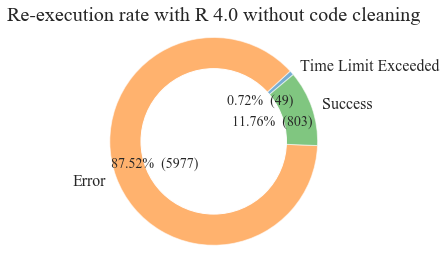

In [21]:
plot_code(df_40_noenv, "Re-execution rate with R 4.0 without code cleaning", "r40_noenv.png")

# Aggregated

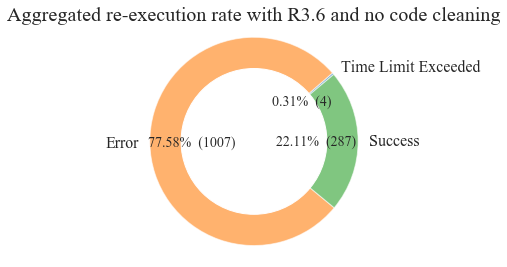

In [22]:
plot_code(df_36_noenv, "Aggregated re-execution rate with R3.6 and no code cleaning", "before_per_package.png", aggregation=True)

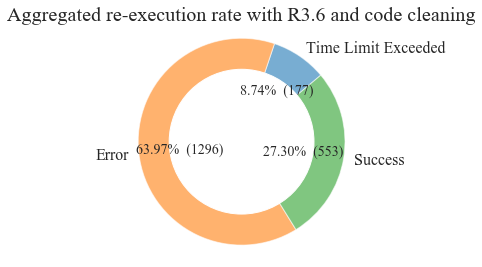

In [23]:
plot_code(df_36_env, "Aggregated re-execution rate with R3.6 and code cleaning", "r36_env.png", aggregation=True)